**Курсовая работа**

**08. Классификация: превышает ли значение SI значение 8**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [6]:
# Загрузка  данных
df_standardscaler = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Classic_ML_Vo_PJ/df_standardscaler.csv')

In [7]:
# Выведим размерность датафрейма
df_standardscaler.shape

(969, 188)

In [8]:
# Выведим первые строки датафрейма
df_standardscaler.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


Преобразуем числовую переменную SI в бинарную (SI > 8), а затем обучим и оценим на моделях классификации на основе этих данных.

Оценка производится по двум ключевым метрикам:

Accuracy — доля правильных предсказаний
ROC AUC — мера качества бинарной классификации, учитывает precision и recall

In [9]:
# Подготовка данных
X = df_standardscaler.drop(columns=['IC50', 'CC50', 'SI'])  # Признаки — исключаем целевые переменные
y = df_standardscaler['SI']  # Целевая переменная — SI

# Преобразуем задачу регрессии в задачу бинарной классификации:
# - 1: если значение SI > 8
# - 0: иначе
y_class = (y > 8).astype(int)

# Разделяем данные на обучающую и тестовую выборки в соотношении 80/20
# stratify=y_class — сохраняем пропорции классов между выборками
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)


def train_and_evaluate_models(X_train, y_train, X_test, y_test, models):
    """
    Обучает модели и оценивает их на тестовой выборке.
    Параметры:
        X_train, X_test — признаки для обучения и тестирования
        y_train, y_test — целевые метки для обучения и тестирования
        models — словарь моделей {имя_модели: модель}
    Возвращает:
        results_df — таблица с результатами (Accuracy и ROC AUC)
    """
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)  # Обучение модели
        y_pred = model.predict(X_test)  # Предсказание классов
        y_proba = model.predict_proba(X_test)[:, 1]  # Вероятности положительного класса

        # Вычисление метрик
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        # Сохранение результатов
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'ROC AUC': roc_auc
        })

    return pd.DataFrame(results)  # Возвращаем DataFrame с результатами


# Словарь моделей для сравнения
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Обучаем и оцениваем все модели
results_df = train_and_evaluate_models(X_train, y_train, X_test, y_test, models)

# Выводим результаты
print("=== Результаты моделирования ===")
print(results_df)

[LightGBM] [Info] Number of positive: 3, number of negative: 772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16846
[LightGBM] [Info] Number of data points in the train set: 775, number of used features: 162
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003871 -> initscore=-5.550372
[LightGBM] [Info] Start training from score -5.550372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

**Построение графика с визуализацией полученных результатов**

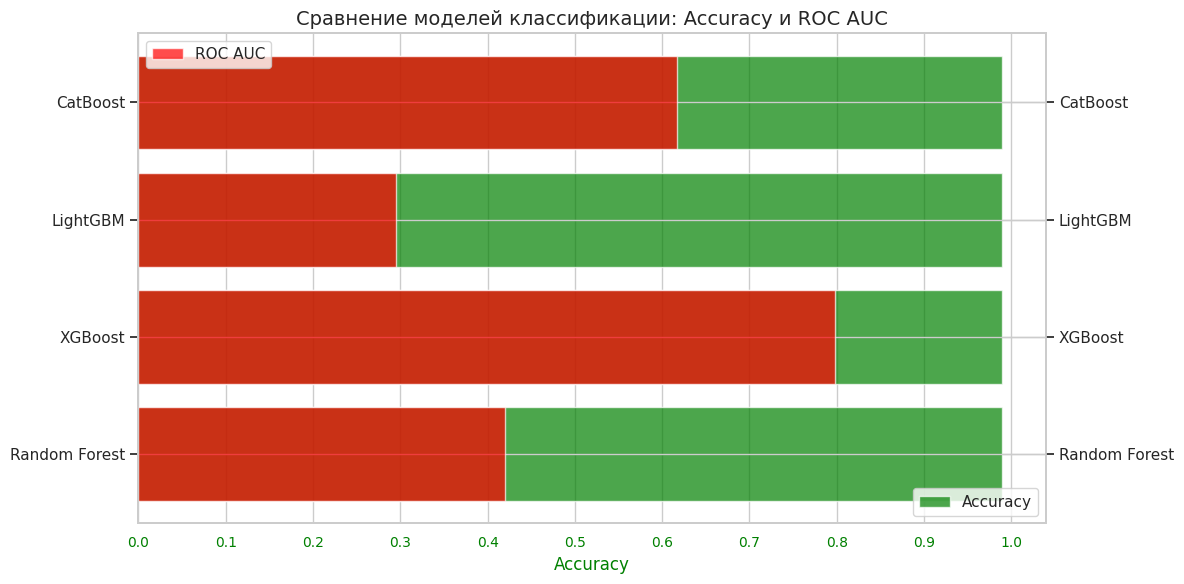

In [22]:
# Настроим стиль графика
sns.set(style="whitegrid")

# Горизонтальная визуализация
fig, ax = plt.subplots(figsize=(12, 6))

# Модели на оси Y
model_names = results_df['Model']

# Точность — левая ось Y (зелёные)
bar1 = ax.barh(model_names, results_df['Accuracy'], color='green', alpha=0.7, label='Accuracy')

# ROC AUC — правая ось Y (красные)
ax2 = ax.twinx()
bar2 = ax2.barh(model_names, results_df['ROC AUC'], color='red', alpha=0.7, label='ROC AUC')

# Устанавливаем сетку с шагом 0.1 для обеих осей
ax.yaxis.grid(True)  # Сетка по оси Y (для Accuracy)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))  # Шаг 0.1 по X для Accuracy
ax.tick_params(axis='x', which='major', labelsize=10)

ax2.yaxis.grid(True)  # Сетка по оси Y (для ROC AUC)
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.1))  # Шаг 0.1 по X для ROC AUC
ax2.tick_params(axis='x', which='major', labelsize=10)

# Подписи
ax.set_xlabel('Accuracy', fontsize=12, color='green')
ax2.set_xlabel('ROC AUC', fontsize=12, color='red')
ax.set_title('Сравнение моделей классификации: Accuracy и ROC AUC', fontsize=14)

# Цвета подписей
ax.tick_params(axis='x', colors='green')
ax2.tick_params(axis='x', colors='red')

# Легенда
ax.legend(loc='lower right')
ax2.legend(loc='upper left')

# Позиционируем метки Y так, чтобы они не повторялись
ax.set_yticks(range(len(model_names)))
ax.set_yticklabels(model_names, fontsize=11)

# Автоматическая коррекция макета
plt.tight_layout()

# Отображаем график
plt.show()

**Основные выводы:**

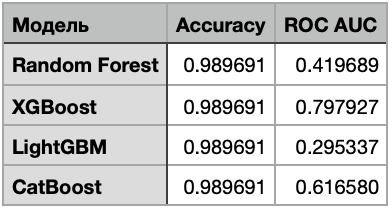


1. Все модели имеют одинаковое значение Accuracy, все модели показывают очень высокую точность (Accuracy ≈ 0.99). Возможно указывать на высокий процент объектов одного класса и модель часто предсказывает доминирующий класс.  Accuracy не является надёжным критерием в данной задаче, так как не отражает баланс между precision и recall.

2. XGBoost превосходит остальные по ROC AUC, у XGBoost наивысшее значение ROC AUC (≈ 0.80), что говорит о том, что он лучше всего справляется с различением положительного и отрицательного классов.
Это делает его наиболее подходящим для задачи, где важны оба класса и нужно учитывать полноту и точность предсказаний.

3. LightGBM имеет наихудший ROC AUC, у LightGBM ROC AUC = 0.295, что почти эквивалентно случайному выбору класса, такой низкий ROC AUC говорит о том, что модель не способна эффективно разделять классы.

4. CatBoost занимает среднюю позицию, имеет ROC AUC = 0.617, что намного выше LightGBM, но ниже XGBoost.

Вывод: CatBoost может быть использован как альтернатива, но не является оптимальной.

XGBoost — лучшая модель по метрике ROC AUC.

LightGBM показывает худшие результаты и требует пересмотра признаков или параметров.

Рекомендации:

Использовать XGBoost как основную модель, если важно качество классификации.
